#SOM 신경망
손글씨 이미지 데이터 구분

In [ ]:
from math import sqrt

from numpy import (array, unravel_index, nditer, linalg, random, subtract,
                   power, exp, pi, zeros, arange, outer, meshgrid, dot)
from collections import defaultdict
from warnings import warn


def fast_norm(x):
    """Returns norm-2 of a 1-D numpy array.

    * faster than linalg.norm in case of 1-D arrays (numpy 1.9.2rc1).
    """
    return sqrt(dot(x, x.T))


class Som:
    def __init__(self,x,y,input_len,sigma=1.0,learning_rate=0.5,random_seed=None):
        """
            Initializes a Self Organizing Maps.
            x,y - dimensions of the SOM
            input_len - number of the elements of the vectors in input
            sigma - spread of the neighborhood function (Gaussian), needs to be adequate to the dimensions of the map.
            (at the iteration t we have sigma(t) = sigma / (1 + t/T) where T is #num_iteration/2)
            learning_rate - initial learning rate
            (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
            random_seed, random seed to use.
        """
        if sigma >= x/2.0 or sigma >= y/2.0:
            warn('Warning: sigma is too high for the dimension of the map.')
        if random_seed:
            self.random_generator = random.RandomState(random_seed)
        else:
            self.random_generator = random.RandomState(random_seed)
        self.learning_rate = learning_rate
        self.sigma = sigma
        self.weights = self.random_generator.rand(x,y,input_len)*2-1 # random initialization
        self.weights = array([v/linalg.norm(v) for v in self.weights]) # normalization
        self.activation_map = zeros((x,y))
        self.neigx = arange(x)
        self.neigy = arange(y) # used to evaluate the neighborhood function
        self.neighborhood = self.gaussian

    def _activate(self,x):
        """ Updates matrix activation_map, in this matrix the element i,j is the response of the neuron i,j to x """
        s = subtract(x,self.weights) # x - w
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.activation_map[it.multi_index] = fast_norm(s[it.multi_index]) # || x - w ||
            it.iternext()

    def activate(self,x):
        """ Returns the activation map to x """
        self._activate(x)
        return self.activation_map

    def gaussian(self,c,sigma):
        """ Returns a Gaussian centered in c """
        d = 2*pi*sigma*sigma
        ax = exp(-power(self.neigx-c[0],2)/d)
        ay = exp(-power(self.neigy-c[1],2)/d)
        return outer(ax,ay) # the external product gives a matrix

    def diff_gaussian(self,c,sigma):
        """ Mexican hat centered in c (unused) """
        xx,yy = meshgrid(self.neigx,self.neigy)
        p = power(xx-c[0],2) + power(yy-c[1],2)
        d = 2*pi*sigma*sigma
        return exp(-(p)/d)*(1-2/d*p)

    def winner(self,x):
        """ Computes the coordinates of the winning neuron for the sample x """
        self._activate(x)
        return unravel_index(self.activation_map.argmin(),self.activation_map.shape)

    def update(self,x,win,t):
        """
            Updates the weights of the neurons.
            x - current pattern to learn
            win - position of the winning neuron for x (array or tuple).
            t - iteration index
        """
        # eta(t) = eta(0) / (1 + t/T) 
        # keeps the learning rate nearly constant for the first T iterations and then adjusts it
        eta = self.learning_rate/(1+t/self.T)
        sig = self.sigma/(1+t/self.T) # sigma and learning rate decrease with the same rule
        g = self.neighborhood(win,sig)*eta # improves the performances
        it = nditer(g, flags=['multi_index'])
        while not it.finished:
            # eta * neighborhood_function * (x-w)
            self.weights[it.multi_index] += g[it.multi_index]*(x-self.weights[it.multi_index])            
            # normalization
            self.weights[it.multi_index] = self.weights[it.multi_index] / fast_norm(self.weights[it.multi_index])
            it.iternext()

    def quantization(self,data):
        """ Assigns a code book (weights vector of the winning neuron) to each sample in data. """
        q = zeros(data.shape)
        for i,x in enumerate(data):
            q[i] = self.weights[self.winner(x)]
        return q


    def random_weights_init(self,data):
        """ Initializes the weights of the SOM picking random samples from data """
        it = nditer(self.activation_map, flags=['multi_index'])
        while not it.finished:
            self.weights[it.multi_index] = data[int(self.random_generator.rand()*len(data)-1)]
            self.weights[it.multi_index] = self.weights[it.multi_index]/fast_norm(self.weights[it.multi_index])
            it.iternext()

    def train_random(self,data,num_iteration):        
        """ Trains the SOM picking samples at random from data """
        self._init_T(num_iteration)        
        for iteration in range(num_iteration):
            rand_i = int(round(self.random_generator.rand()*len(data)-1)) # pick a random sample
            self.update(data[rand_i],self.winner(data[rand_i]),iteration)

    def train_batch(self,data,num_iteration):
        """ Trains using all the vectors in data sequentially """
        self._init_T(len(data)*num_iteration)
        iteration = 0
        while iteration < num_iteration:
            idx = iteration % (len(data)-1)
            self.update(data[idx],self.winner(data[idx]),iteration)
            iteration += 1

    def _init_T(self,num_iteration):
        """ Initializes the parameter T needed to adjust the learning rate """
        self.T = num_iteration/2 # keeps the learning rate nearly constant for the first half of the iterations

    def distance_map(self):
        """ Returns the average distance map of the weights.
            (Each mean is normalized in order to sum up to 1) """
        um = zeros((self.weights.shape[0],self.weights.shape[1]))
        it = nditer(um, flags=['multi_index'])
        while not it.finished:
            for ii in range(it.multi_index[0]-1,it.multi_index[0]+2):
                for jj in range(it.multi_index[1]-1,it.multi_index[1]+2):
                    if ii >= 0 and ii < self.weights.shape[0] and jj >= 0 and jj < self.weights.shape[1]:
                        um[it.multi_index] += fast_norm(self.weights[ii,jj,:]-self.weights[it.multi_index])
            it.iternext()
        um = um/um.max()
        return um

    def activation_response(self,data):
        """ 
            Returns a matrix where the element i,j is the number of times
            that the neuron i,j have been winner.
        """
        a = zeros((self.weights.shape[0],self.weights.shape[1]))
        for x in data:
            a[self.winner(x)] += 1
        return a

    def quantization_error(self,data):
        """ 
            Returns the quantization error computed as the average distance between
            each input sample and its best matching unit.            
        """
        error = 0
        for x in data:
            error += fast_norm(x-self.weights[self.winner(x)])
        return error/len(data)

    def win_map(self,data):
        """
            Returns a dictionary wm where wm[(i,j)] is a list with all the patterns
            that have been mapped in the position i,j.
        """
        winmap = defaultdict(list)
        for x in data:
            winmap[self.winner(x)].append(x)
        return winmap

### unit tests
from numpy.testing import assert_almost_equal, assert_array_almost_equal, assert_array_equal

class TestSom:
    def setup_method(self, method):
        self.som = Som(5,5,1)
        for w in self.som.weights: # checking weights normalization
            assert_almost_equal(1.0,linalg.norm(w))
        self.som.weights = zeros((5,5)) # fake weights
        self.som.weights[2,3] = 5.0
        self.som.weights[1,1] = 2.0

    def test_fast_norm(self):
        assert fast_norm(array([1,3])) == sqrt(1+9)

    def test_gaussian(self):
        bell = self.som.gaussian((2,2),1)
        assert bell.max() == 1.0
        assert bell.argmax() == 12  # unravel(12) = (2,2)

    def test_win_map(self):
        winners = self.som.win_map([5.0,2.0])
        assert winners[(2,3)][0] == 5.0
        assert winners[(1,1)][0] == 2.0

    def test_activation_reponse(self):
        response = self.som.activation_response([5.0,2.0])
        assert response[2,3] == 1
        assert response[1,1] == 1

    def test_activate(self):
        assert self.som.activate(5.0).argmin() == 13.0  # unravel(13) = (2,3)
     
    def test_quantization_error(self):
        self.som.quantization_error([5,2]) == 0.0
        self.som.quantization_error([4,1]) == 0.5

    def test_quantization(self):
        q = self.som.quantization(array([4,2]))
        assert q[0] == 5.0
        assert q[1] == 2.0

    def test_random_seed(self):
        som1 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        som2 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        assert_array_almost_equal(som1.weights,som2.weights) # same initialization
        data = random.rand(100,2)
        som1 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        som1.train_random(data,10)
        som2 = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        som2.train_random(data,10)
        assert_array_almost_equal(som1.weights,som2.weights) # same state after training

    def test_train_batch(self):
        som = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        data = array([[4,2],[3,1]])
        q1 = som.quantization_error(data)
        som.train_batch(data,10)
        assert q1 > som.quantization_error(data)

    def test_train_random(self):
        som = Som(5,5,2,sigma=1.0,learning_rate=0.5,random_seed=1)
        data = array([[4,2],[3,1]])
        q1 = som.quantization_error(data)
        som.train_random(data,10)
        assert q1 > som.quantization_error(data)

    def test_random_weights_init(self):
        som = Som(2,2,2,random_seed=1)
        som.random_weights_init(array([[1.0,.0]]))
        for w in som.weights:
            assert_array_equal(w[0],array([1.0,.0]))


In [ ]:
import numpy as mp

from sklearn.datasets import load_digits
from pylab import plot, axis, show, pcolor, colorbar, bone

In [ ]:
digits = load_digits()
data = digits.data
labels = digits.target


Initiating SOM
SOM Processing Complete


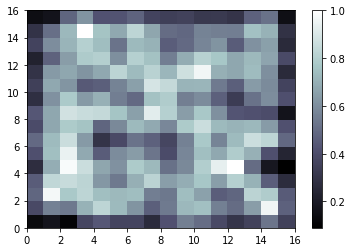

In [ ]:
#SOM 모델링
som = Som(16,16,64, sigma = 1.0, learning_rate = 0.5)
#sigma : 가우시안 네이버후드 함수의 분포 정도
#learning rate : SOM의 초기 학습 속도를 스스로 컨트롤할 수 있는 값
som.random_weights_init(data)

print("Initiating SOM")

som.train_random(data, 10000)
print("SOM Processing Complete")

bone()
pcolor(som.distance_map().T)
colorbar()

#합성곱 신경망
MNIST 데이터

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

# 1. MNIST 데이터셋 불러오기
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# 2. 데이터 전처리하기
train_images = train_images.reshape((60000, 28, 28, 1))
test_images = test_images.reshape((10000, 28, 28, 1))
train_images, test_images = train_images / 255.0, test_images / 255.0


In [ ]:
# 3. 합성곱 신경망 구성하기
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 64)        

In [ ]:
# 4. 모델 컴파일하기
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# 5. 훈련하기
model.fit(train_images, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 57s 30ms/step - loss: 0.2153 - accuracy: 0.9341
Epoch 2/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0777 - accuracy: 0.9762
Epoch 3/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0541 - accuracy: 0.9835
Epoch 4/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0430 - accuracy: 0.9867
Epoch 5/5
1875/1875 [==============================] - 56s 30ms/step - loss: 0.0344 - accuracy: 0.9888


In [ ]:
# 6. 모델 평가하기
loss, acc = model.evaluate(test_images, test_labels, verbose=2)

313/313 - 3s - loss: 0.0588 - accuracy: 0.9860 - 3s/epoch - 9ms/step
